In [1]:
import sys
from pathlib import Path
notebook_dir = Path().resolve()
project_root = notebook_dir.parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from src.neural_network import NeuralNetwork
from src.activations import Sigmoid, Linear
from src.losses import MSE
from src.optimizers import GD, RMSprop, Adam
from src.training import train
from src.metrics import mse
from src.utils import runge, polynomial_features, scale_data, OLS_parameters, inverse_scale_y, find_best_eta, find_best_N_eta
from src.plotting import plot_learning_curves, N_eta_heatmap

# Setup for OLS Regression

In [2]:
SEED = 42
np.random.seed(SEED)
SIGMA = 0.1

N = 300
x = np.linspace(-1, 1, N)
y_true = runge(x)
y_noise = y_true + np.random.normal(0, SIGMA, N)

In [3]:
X_poly = polynomial_features(x, p=14, intercept=False)

X_train_poly, X_test_poly, y_train, y_test = train_test_split(
    X_poly, y_noise, test_size=0.2, random_state=SEED
)
# Scale data
X_train_s, y_train_s, X_mean, X_std, y_mean = scale_data(X_train_poly, y_train)
X_test_s, y_test_s, _, _, _ = scale_data(
    X_test_poly, y_test, X_mean, X_std, y_mean
)

theta_ols = OLS_parameters(X_train_s, y_train_s)
y_pred_ols = X_test_s @ theta_ols
ols_mse = mse(y_test_s.reshape(-1, 1), y_pred_ols.reshape(-1, 1))

print(f"OLS Test MSE: {ols_mse:.6f}")

OLS Test MSE: 0.007290


# Parameters and setup for FFNN

In [4]:
# Experiment 1: one hidden layer and 50 hidden nodes
layer_sizes_1 = [50, 1]
activations_1 = [Sigmoid(), Linear()]


# Experiment 2: two hidden layers and 100 hidden nodes each
layer_sizes_2 = [100, 100, 1]
activations_2 = [Sigmoid(), Sigmoid(), Linear()]


EPOCHS = 500
BATCH_SIZE = 32
TEST_SIZE=0.2
LOSS = MSE()
NETWORK_INPUT_SIZE = 1

ETA_VALS = np.logspace(-5, -1, 10)
N_VALS = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]

# Full batch Gradient Descent

## Find best $\eta$ and N for GD

### Experiment 1: One hidden layer & 50 hidden nodes


BEST COMBINATION:
  N = 500
  η = 0.035938
  Test MSE = 0.019312
  Train MSE = 0.037411



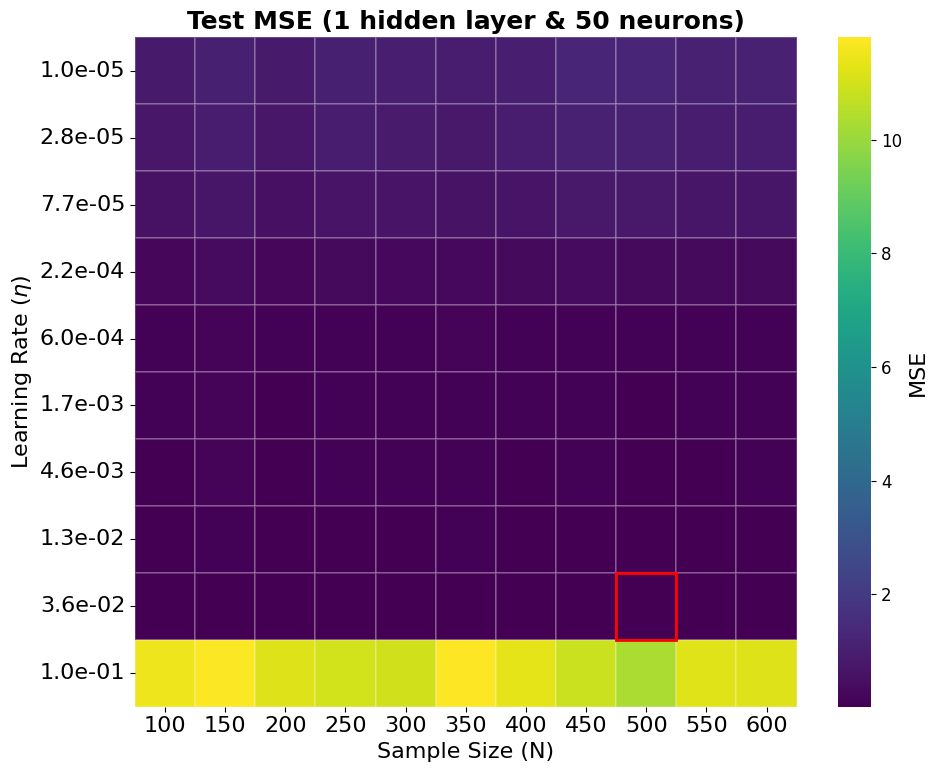

In [5]:
test_mse_gd_1, train_mse_gd_1, best_eta_gd_1, best_N_gd_1 = find_best_N_eta(
    N_VALS, ETA_VALS, layer_sizes_1, activations_1,
    optimizer_type='gd', epochs=500, batch_size=32
)

# Plot test MSE heatmap
N_eta_heatmap(test_mse_gd_1, N_VALS, ETA_VALS, 
              metric_name='MSE', dataset='Test', title='1 hidden layer & 50 neurons')
plt.savefig('figs/N_eta_gd_heatmap_exp1.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Experiment 2: Two hidden layers & 100 hidden nodes


BEST COMBINATION:
  N = 200
  η = 0.012915
  Test MSE = 0.007668
  Train MSE = 0.012831



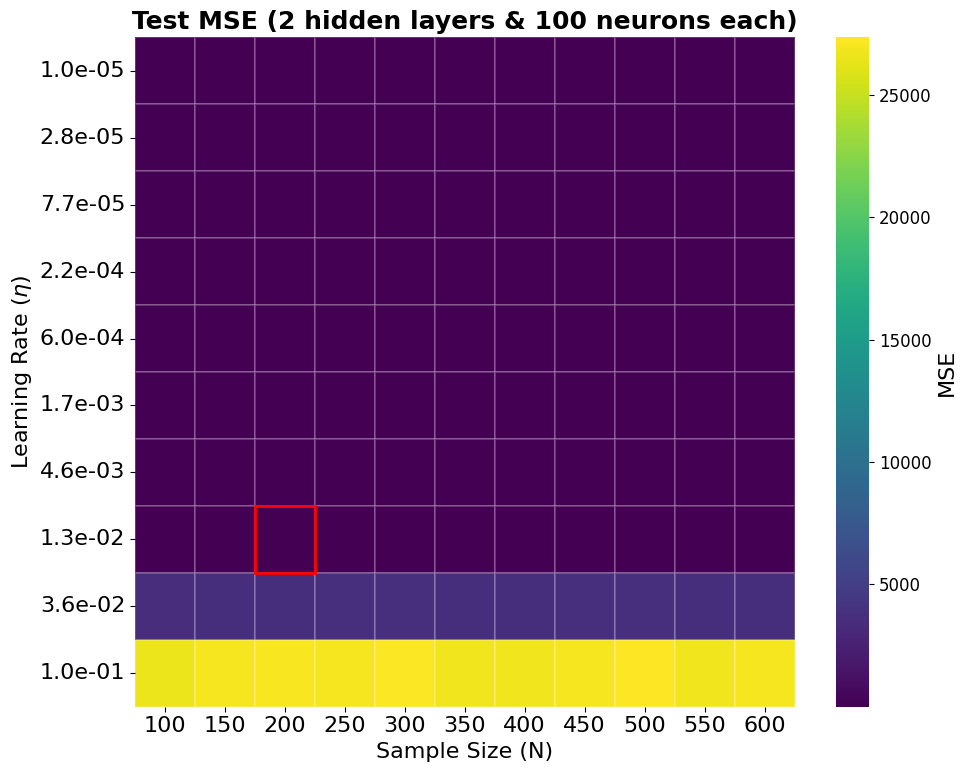

In [6]:
test_mse_gd_2, train_mse_gd_2, best_eta_gd_2, best_N_gd_2 = find_best_N_eta(
    N_VALS, ETA_VALS, layer_sizes_2, activations_2,
    optimizer_type='gd', epochs=500, batch_size=32
)

# Plot test MSE heatmap
N_eta_heatmap(test_mse_gd_2, N_VALS, ETA_VALS, 
              metric_name='MSE', dataset='Test', title='2 hidden layers & 100 neurons each')
plt.savefig('figs/N_eta_gd_heatmap_exp2.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [7]:
print(f"Experiment 1: Best η: {best_eta_gd_1:.6f}, best N = {best_N_gd_1}, Best Test MSE: {np.min(test_mse_gd_1):.6f}")
print(f"Experiment 2: Best η: {best_eta_gd_2:.6f}, best N = {best_N_gd_2}, Best Test MSE: {np.min(test_mse_gd_2):.6f}")

Experiment 1: Best η: 0.035938, best N = 500, Best Test MSE: 0.019312
Experiment 2: Best η: 0.012915, best N = 200, Best Test MSE: 0.007668


### FFNN for experiment 1 

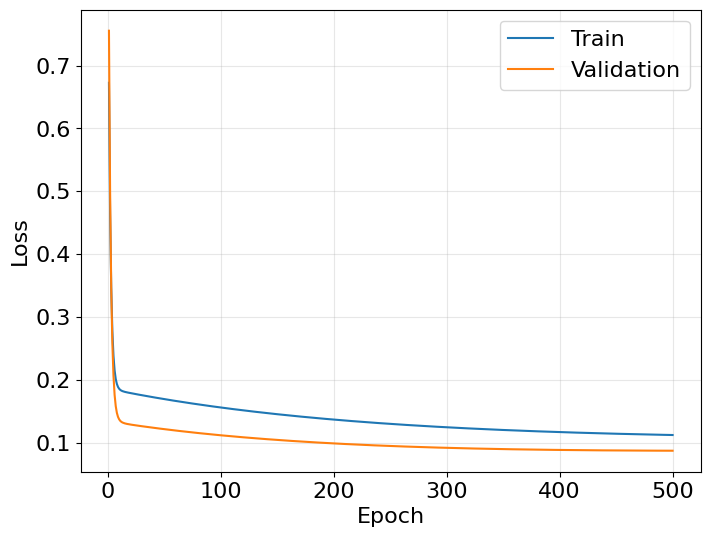

Final Train MSE (scaled): 0.111997
Final Test MSE (scaled): 0.087005
Final Test MSE (original scale): 0.087005


In [8]:
x = np.linspace(-1, 1, best_N_gd_1)
y_true = runge(x)
y_noise = y_true + np.random.normal(0, 0.3, best_N_gd_1)

# Split data
X_train_raw, X_test_raw, y_train_nn, y_test_nn = train_test_split(
    x.reshape(-1, 1), y_noise.reshape(-1, 1), 
    test_size=TEST_SIZE, random_state=SEED
)

# Scale data
X_train_s, y_train_s, X_mean, X_std, y_mean = scale_data(
    X_train_raw, y_train_nn
)
X_test_s, y_test_s, _, _, _ = scale_data(
    X_test_raw, y_test_nn, X_mean, X_std, y_mean
)

nn_gd_1 = NeuralNetwork(
    network_input_size=NETWORK_INPUT_SIZE,
    layer_output_sizes=layer_sizes_1,
    activations=activations_1,
    loss=LOSS,
    seed=SEED
)


history = train(
            nn=nn_gd_1,
            X_train=X_train_s,
            y_train=y_train_s,
            X_val=X_test_s,
            y_val=y_test_s,
            optimizer=GD(eta=best_eta_gd_1),
            epochs=EPOCHS,
            batch_size=len(X_train_s),  # Full batch
            stochastic=False,
            task='regression',
            tol_relative=0.0,
            tol_absolute=0.0,
            early_stopping=False,
            patience=10,
            verbose=False,
            seed=SEED
        )


train_loss = history['train_loss']  
val_loss = history['val_loss']      


plot_learning_curves(train_loss, val_loss)

print(f"Final Train MSE (scaled): {train_loss[-1]:.6f}")
print(f"Final Test MSE (scaled): {val_loss[-1]:.6f}")

# These predictions are SCALED (not original)
y_train_pred_scaled = nn_gd_1.predict(X_train_s)  # Network outputs scaled predictions
y_test_pred_scaled = nn_gd_1.predict(X_test_s)    # Network outputs scaled predictions

# NOW we transform to original scale
y_train_pred = inverse_scale_y(y_train_pred_scaled, y_mean)  # NOW it's original
y_test_pred = inverse_scale_y(y_test_pred_scaled, y_mean)    # NOW it's original

# THESE are on original scale
train_mse_original = mse(y_train_nn, y_train_pred)  # Original scale MSE
test_mse_original = mse(y_test_nn, y_test_pred)     # Original scale MSE
print(f"Final Test MSE (original scale): {test_mse_original:.6f}")

### FFNN for experiment 2

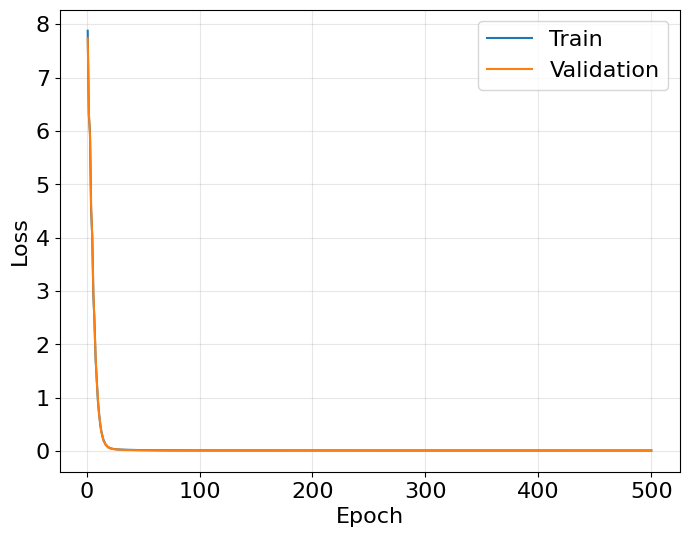

Final Train MSE (scaled): 0.012831
Final Test MSE (scaled): 0.007668
Final Test MSE (original scale): 0.007668


In [9]:
x = np.linspace(-1, 1, best_N_gd_2)
y_true = runge(x)
y_noise = y_true + np.random.normal(0, SIGMA, best_N_gd_2)

# Split data
X_train_raw, X_test_raw, y_train_nn, y_test_nn = train_test_split(
    x.reshape(-1, 1), y_noise.reshape(-1, 1), 
    test_size=TEST_SIZE, random_state=SEED
)

# Scale data
X_train_s, y_train_s, X_mean, X_std, y_mean = scale_data(
    X_train_raw, y_train_nn
)
X_test_s, y_test_s, _, _, _ = scale_data(
    X_test_raw, y_test_nn, X_mean, X_std, y_mean
)

nn_gd_2 = NeuralNetwork(
    network_input_size=NETWORK_INPUT_SIZE,
    layer_output_sizes=layer_sizes_2,
    activations=activations_2,
    loss=LOSS,
    seed=SEED
)


history = train(
            nn=nn_gd_2,
            X_train=X_train_s,
            y_train=y_train_s,
            X_val=X_test_s,
            y_val=y_test_s,
            optimizer=GD(eta=best_eta_gd_2),
            epochs=EPOCHS,
            batch_size=len(X_train_s),  # Full batch
            stochastic=False,
            task='regression',
            tol_relative=0.0,
            tol_absolute=0.0,
            early_stopping=False,
            patience=10,
            verbose=False,
            seed=SEED
        )


train_loss = history['train_loss']  
val_loss = history['val_loss']      


plot_learning_curves(train_loss, val_loss)

print(f"Final Train MSE (scaled): {train_loss[-1]:.6f}")
print(f"Final Test MSE (scaled): {val_loss[-1]:.6f}")

# These predictions are SCALED (not original)
y_train_pred_scaled = nn_gd_2.predict(X_train_s)  # Network outputs scaled predictions
y_test_pred_scaled = nn_gd_2.predict(X_test_s)    # Network outputs scaled predictions

# NOW we transform to original scale
y_train_pred = inverse_scale_y(y_train_pred_scaled, y_mean)  # NOW it's original
y_test_pred = inverse_scale_y(y_test_pred_scaled, y_mean)    # NOW it's original

# THESE are on original scale
train_mse_original = mse(y_train_nn, y_train_pred)  # Original scale MSE
test_mse_original = mse(y_test_nn, y_test_pred)     # Original scale MSE
print(f"Final Test MSE (original scale): {test_mse_original:.6f}")

# Stochastic Gradient Descent with RMSprop

## Find best $\eta$ and N for RMSprop

### Experiment 1: One hidden layer & 50 hidden nodes


BEST COMBINATION:
  N = 100
  η = 0.012915
  Test MSE = 0.007387
  Train MSE = 0.011473



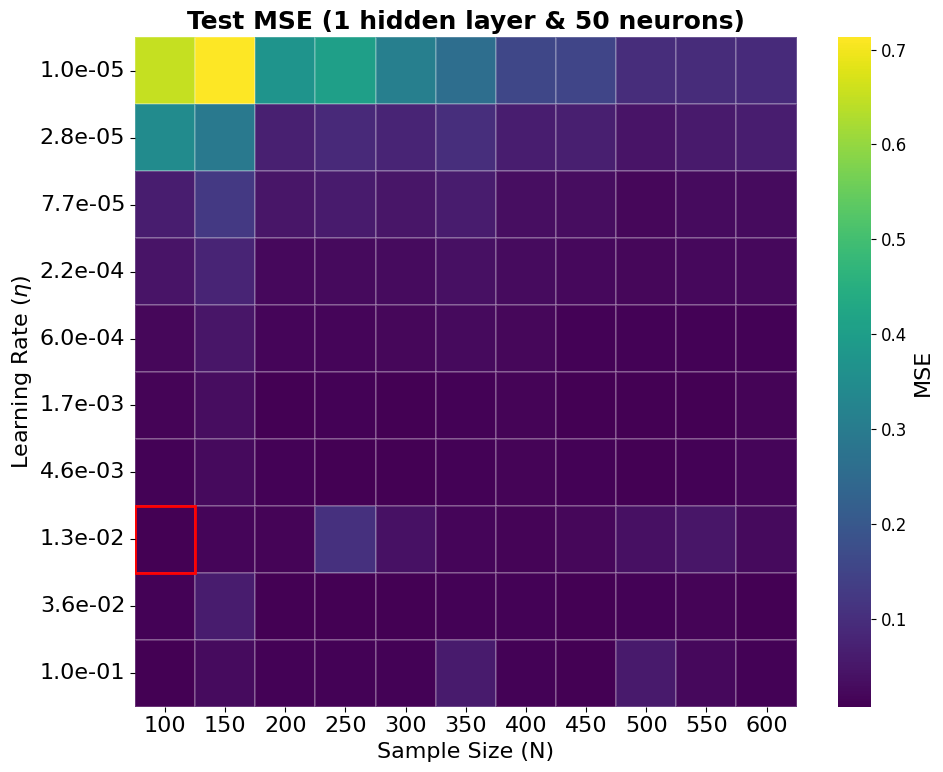

In [10]:
test_mse_rms_1, train_mse_rms_1, best_eta_rms_1, best_N_rms_1 = find_best_N_eta(
    N_VALS, ETA_VALS, layer_sizes_1, activations_1,
    optimizer_type='rmsprop', epochs=500, batch_size=32
)

# Plot test MSE heatmap
N_eta_heatmap(test_mse_rms_1, N_VALS, ETA_VALS, 
              metric_name='MSE', dataset='Test', title='1 hidden layer & 50 neurons')
plt.savefig('figs/N_eta_rms_heatmap_exp1.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Experiment 2: Two hidden layer & 100 hidden nodes


BEST COMBINATION:
  N = 100
  η = 0.001668
  Test MSE = 0.007715
  Train MSE = 0.008738



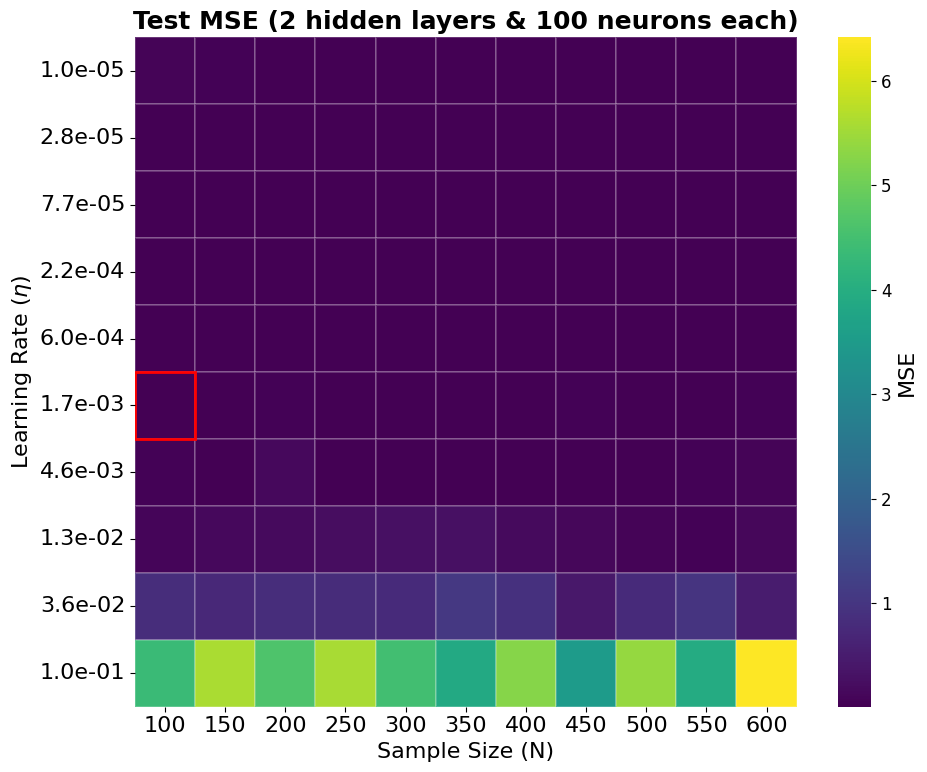

In [11]:
test_mse_rms_2, train_mse_rms_2, best_eta_rms_2, best_N_rms_2 = find_best_N_eta(
    N_VALS, ETA_VALS, layer_sizes_2, activations_2,
    optimizer_type='rmsprop', epochs=500, batch_size=32
)

# Plot test MSE heatmap
N_eta_heatmap(test_mse_rms_2, N_VALS, ETA_VALS, 
              metric_name='MSE', dataset='Test', title='2 hidden layers & 100 neurons each')
plt.savefig('figs/N_eta_rms_heatmap_exp2.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [12]:
print(f"Experiment 1: Best η: {best_eta_rms_1:.6f}, best N = {best_N_rms_1}, Best Test MSE: {np.min(test_mse_rms_1):.6f}")
print(f"Experiment 2: Best η: {best_eta_rms_2:.6f}, best N = {best_N_rms_2}, Best Test MSE: {np.min(test_mse_rms_2):.6f}")

Experiment 1: Best η: 0.012915, best N = 100, Best Test MSE: 0.007387
Experiment 2: Best η: 0.001668, best N = 100, Best Test MSE: 0.007715


### FFNN for experiment 1

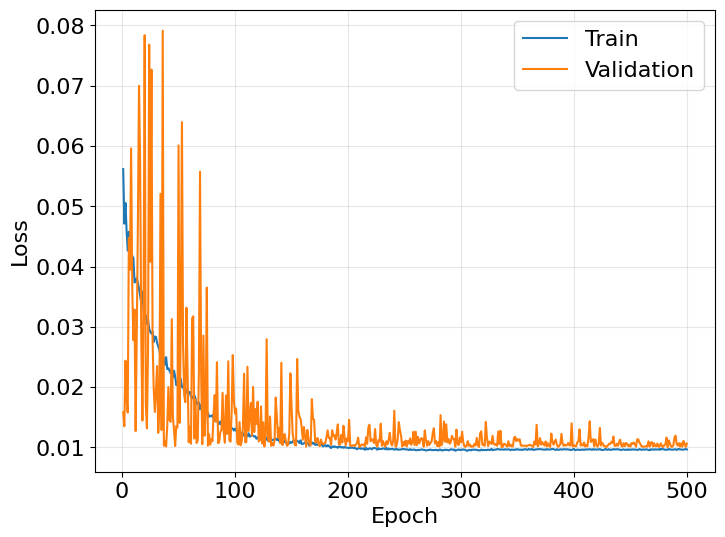

Final Train MSE (scaled): 0.009678
Final Test MSE (scaled): 0.010646
Final Test MSE (original scale): 1.086432


In [ ]:
# x = np.linspace(-1, 1, best_N_rms_1)
x = np.linspace(-1, 1, 5000)
y_true = runge(x)
y_noise = y_true + np.random.normal(0, 0.1, 5000)

# Split data
X_train_raw, X_test_raw, y_train_nn, y_test_nn = train_test_split(
    x.reshape(-1, 1), y_noise.reshape(-1, 1), 
    test_size=TEST_SIZE, random_state=SEED
)

# Scale data
X_train_s, y_train_s, X_mean, X_std, y_mean = scale_data(
    X_train_raw, y_train_nn
)
X_test_s, y_test_s, _, _, _ = scale_data(
    X_test_raw, y_test_nn, X_mean, X_std, y_mean
)

nn_rms_1 = NeuralNetwork(
    network_input_size=NETWORK_INPUT_SIZE,
    layer_output_sizes=layer_sizes_1,
    activations=activations_1,
    loss=LOSS,
    seed=SEED
)


history = train(
            nn=nn_gd_1,
            X_train=X_train_s,
            y_train=y_train_s,
            X_val=X_test_s,
            y_val=y_test_s,
            optimizer=RMSprop(eta=best_eta_rms_1),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE, 
            stochastic=True,
            task='regression',
            early_stopping=False,
            patience=10,
            verbose=False,
            seed=SEED
        )


train_loss = history['train_loss']  
val_loss = history['val_loss']      


plot_learning_curves(train_loss, val_loss)

print(f"Final Train MSE (scaled): {train_loss[-1]:.6f}")
print(f"Final Test MSE (scaled): {val_loss[-1]:.6f}")

# These predictions are SCALED (not original)
y_train_pred_scaled = nn_rms_1.predict(X_train_s)  # Network outputs scaled predictions
y_test_pred_scaled = nn_rms_1.predict(X_test_s)    # Network outputs scaled predictions

# NOW we transform to original scale
y_train_pred = inverse_scale_y(y_train_pred_scaled, y_mean)  # NOW it's original
y_test_pred = inverse_scale_y(y_test_pred_scaled, y_mean)    # NOW it's original

# THESE are on original scale
train_mse_original = mse(y_train_nn, y_train_pred)  # Original scale MSE
test_mse_original = mse(y_test_nn, y_test_pred)     # Original scale MSE
print(f"Final Test MSE (original scale): {test_mse_original:.6f}")

### FFNN for experiment 2

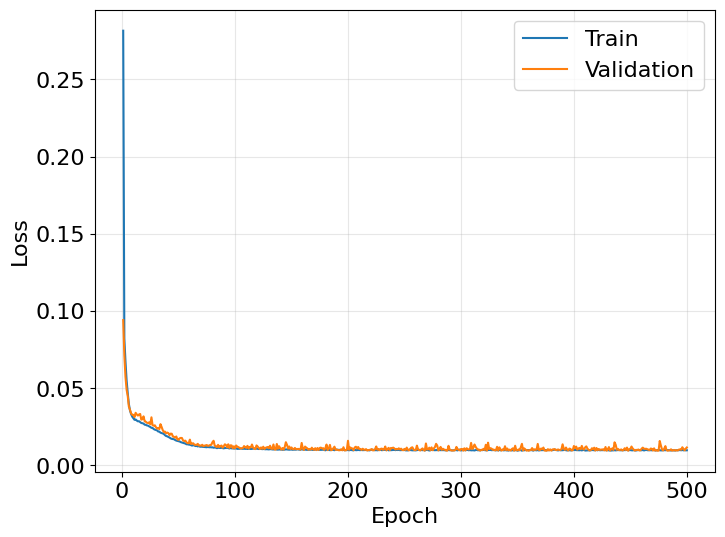

Final Train MSE (scaled): 0.009828
Final Test MSE (scaled): 0.011630
Final Test MSE (original scale): 0.011630


In [ ]:
x = np.linspace(-1, 1, best_N_rms_2)
y_true = runge(x)
y_noise = y_true + np.random.normal(0, SIGMA, best_N_rms_2)

# Split data
X_train_raw, X_test_raw, y_train_nn, y_test_nn = train_test_split(
    x.reshape(-1, 1), y_noise.reshape(-1, 1), 
    test_size=TEST_SIZE, random_state=SEED
)

# Scale data
X_train_s, y_train_s, X_mean, X_std, y_mean = scale_data(
    X_train_raw, y_train_nn
)
X_test_s, y_test_s, _, _, _ = scale_data(
    X_test_raw, y_test_nn, X_mean, X_std, y_mean
)

nn_rms_2 = NeuralNetwork(
    network_input_size=NETWORK_INPUT_SIZE,
    layer_output_sizes=layer_sizes_1,
    activations=activations_1,
    loss=LOSS,
    seed=SEED
)


history = train(
            nn=nn_rms_2,
            X_train=X_train_s,
            y_train=y_train_s,
            X_val=X_test_s,
            y_val=y_test_s,
            optimizer=RMSprop(eta=best_eta_rms_2),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE, 
            stochastic=True,
            task='regression',
            early_stopping=False,
            patience=10,
            verbose=False,
            seed=SEED
        )


train_loss = history['train_loss']  
val_loss = history['val_loss']      


plot_learning_curves(train_loss, val_loss)

print(f"Final Train MSE (scaled): {train_loss[-1]:.6f}")
print(f"Final Test MSE (scaled): {val_loss[-1]:.6f}")

# These predictions are SCALED (not original)
y_train_pred_scaled = nn_rms_2.predict(X_train_s)  # Network outputs scaled predictions
y_test_pred_scaled = nn_rms_2.predict(X_test_s)    # Network outputs scaled predictions

# NOW we transform to original scale
y_train_pred = inverse_scale_y(y_train_pred_scaled, y_mean)  # NOW it's original
y_test_pred = inverse_scale_y(y_test_pred_scaled, y_mean)    # NOW it's original

# THESE are on original scale
train_mse_original = mse(y_train_nn, y_train_pred)  # Original scale MSE
test_mse_original = mse(y_test_nn, y_test_pred)     # Original scale MSE
print(f"Final Test MSE (original scale): {test_mse_original:.6f}")

# Stochastic Gradient Descent with Adam

## Find best $\eta$ and N for Adam

### Experiment 1: One hidden layer & 50 hidden nodes


BEST COMBINATION:
  N = 450
  η = 0.035938
  Test MSE = 0.006450
  Train MSE = 0.010332



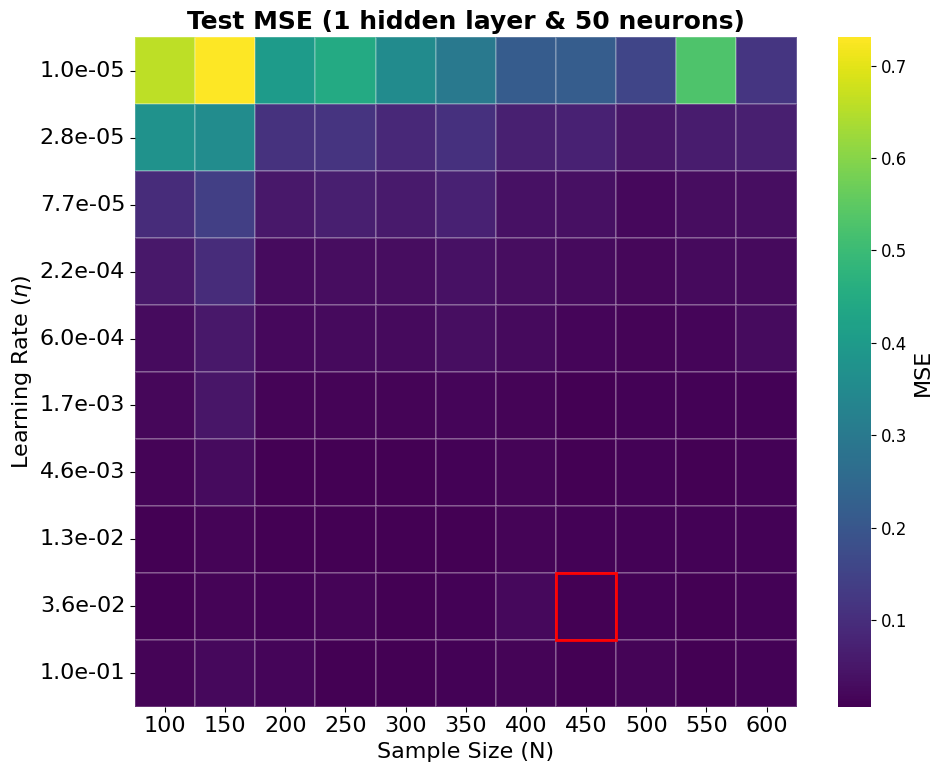

In [15]:
test_mse_adam_1, train_mse_adam_1, best_eta_adam_1, best_N_adam_1 = find_best_N_eta(
    N_VALS, ETA_VALS, layer_sizes_1, activations_1,
    optimizer_type='adam', epochs=500, batch_size=32
)

# Plot test MSE heatmap
N_eta_heatmap(test_mse_adam_1, N_VALS, ETA_VALS, 
              metric_name='MSE', dataset='Test', title='1 hidden layer & 50 neurons')
plt.savefig('figs/N_eta_adam_heatmap_exp1.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Experiment 2: Two hidden layer & 100 hidden nodes


BEST COMBINATION:
  N = 450
  η = 0.035938
  Test MSE = 0.006450
  Train MSE = 0.010332



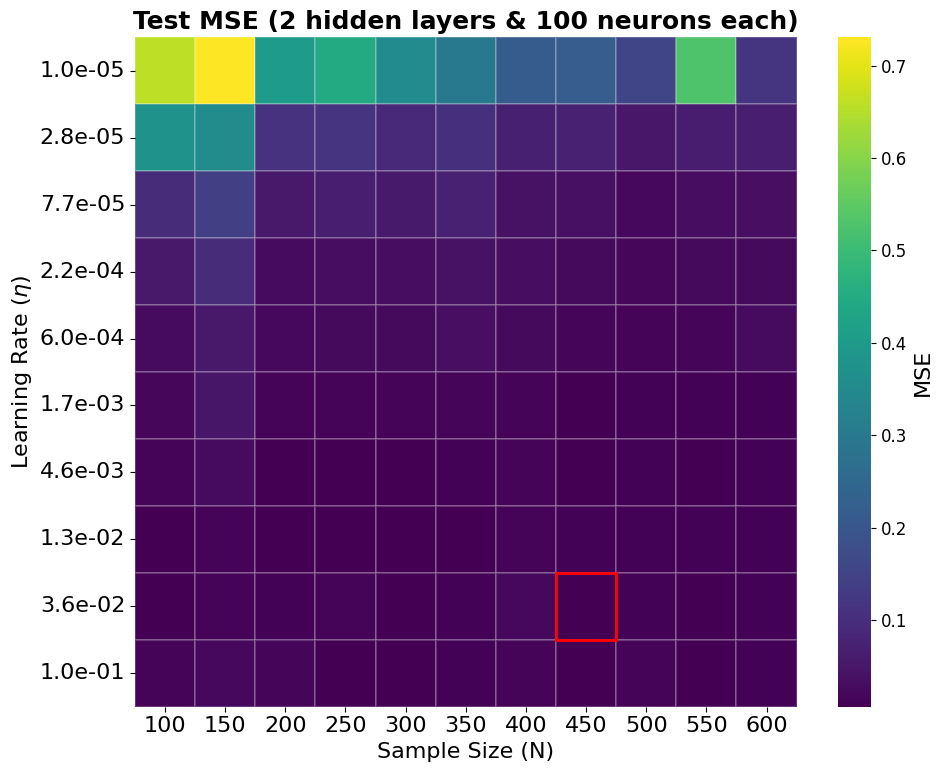

In [16]:
test_mse_adam_2, train_mse_adam_2, best_eta_adam_2, best_N_adam_2 = find_best_N_eta(
    N_VALS, ETA_VALS, layer_sizes_1, activations_1,
    optimizer_type='adam', epochs=500, batch_size=32
)

# Plot test MSE heatmap
N_eta_heatmap(test_mse_adam_2, N_VALS, ETA_VALS, 
              metric_name='MSE', dataset='Test', title='2 hidden layers & 100 neurons each')
plt.savefig('figs/N_eta_adam_heatmap_exp2.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [17]:
print(f"Experiment 1: Best η: {best_eta_adam_1:.6f}, best N = {best_N_adam_1}, Best Test MSE: {np.min(test_mse_adam_1):.6f}")
print(f"Experiment 2: Best η: {best_eta_adam_2:.6f}, best N = {best_N_adam_2}, Best Test MSE: {np.min(test_mse_adam_2):.6f}")

Experiment 1: Best η: 0.035938, best N = 450, Best Test MSE: 0.006450
Experiment 2: Best η: 0.035938, best N = 450, Best Test MSE: 0.006450


### FFNN for experiment 1

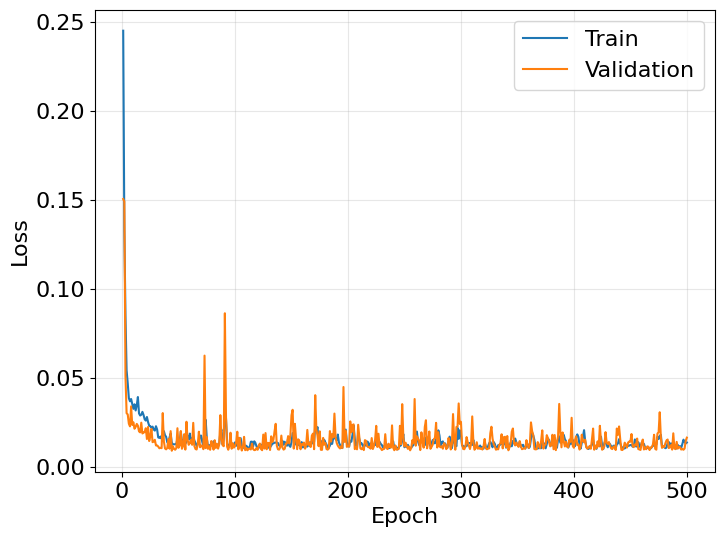

Final Train MSE (scaled): 0.013663
Final Test MSE (scaled): 0.016415
Final Test MSE (original scale): 0.016415


In [18]:
x = np.linspace(-1, 1, best_N_adam_1)
y_true = runge(x)
y_noise = y_true + np.random.normal(0, SIGMA, best_N_adam_1)

# Split data
X_train_raw, X_test_raw, y_train_nn, y_test_nn = train_test_split(
    x.reshape(-1, 1), y_noise.reshape(-1, 1), 
    test_size=TEST_SIZE, random_state=SEED
)

# Scale data
X_train_s, y_train_s, X_mean, X_std, y_mean = scale_data(
    X_train_raw, y_train_nn
)
X_test_s, y_test_s, _, _, _ = scale_data(
    X_test_raw, y_test_nn, X_mean, X_std, y_mean
)

nn_adam_1 = NeuralNetwork(
    network_input_size=NETWORK_INPUT_SIZE,
    layer_output_sizes=layer_sizes_1,
    activations=activations_1,
    loss=LOSS,
    seed=SEED
)


history = train(
            nn=nn_adam_1,
            X_train=X_train_s,
            y_train=y_train_s,
            X_val=X_test_s,
            y_val=y_test_s,
            optimizer=Adam(eta=best_eta_adam_1),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE, 
            stochastic=True,
            task='regression',
            early_stopping=False,
            patience=10,
            verbose=False,
            seed=SEED
        )


train_loss = history['train_loss']  
val_loss = history['val_loss']      


plot_learning_curves(train_loss, val_loss)

print(f"Final Train MSE (scaled): {train_loss[-1]:.6f}")
print(f"Final Test MSE (scaled): {val_loss[-1]:.6f}")

# These predictions are SCALED (not original)
y_train_pred_scaled = nn_adam_1.predict(X_train_s)  # Network outputs scaled predictions
y_test_pred_scaled = nn_adam_1.predict(X_test_s)    # Network outputs scaled predictions

# NOW we transform to original scale
y_train_pred = inverse_scale_y(y_train_pred_scaled, y_mean)  # NOW it's original
y_test_pred = inverse_scale_y(y_test_pred_scaled, y_mean)    # NOW it's original

# THESE are on original scale
train_mse_original = mse(y_train_nn, y_train_pred)  # Original scale MSE
test_mse_original = mse(y_test_nn, y_test_pred)     # Original scale MSE
print(f"Final Test MSE (original scale): {test_mse_original:.6f}")

### FFNN for experiment 2

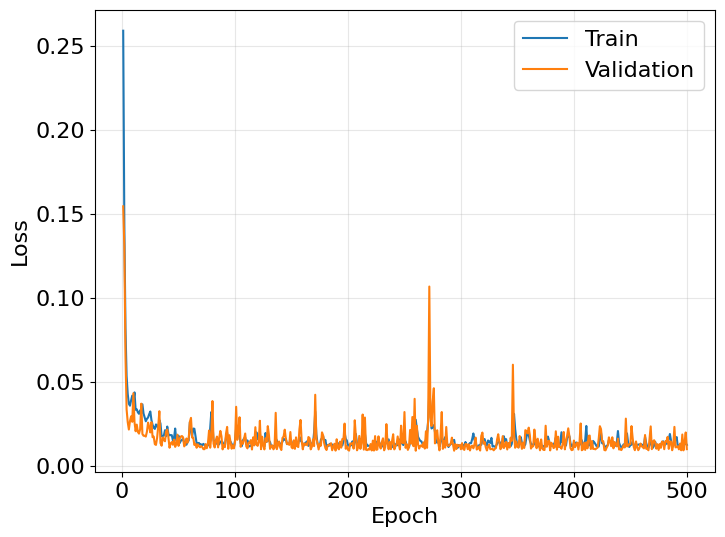

Final Train MSE (scaled): 0.012332
Final Test MSE (scaled): 0.009810
Final Test MSE (original scale): 0.009810


In [19]:
x = np.linspace(-1, 1, best_N_adam_2)
y_true = runge(x)
y_noise = y_true + np.random.normal(0, SIGMA, best_N_adam_2)

# Split data
X_train_raw, X_test_raw, y_train_nn, y_test_nn = train_test_split(
    x.reshape(-1, 1), y_noise.reshape(-1, 1), 
    test_size=TEST_SIZE, random_state=SEED
)

# Scale data
X_train_s, y_train_s, X_mean, X_std, y_mean = scale_data(
    X_train_raw, y_train_nn
)
X_test_s, y_test_s, _, _, _ = scale_data(
    X_test_raw, y_test_nn, X_mean, X_std, y_mean
)

nn_adam_2 = NeuralNetwork(
    network_input_size=NETWORK_INPUT_SIZE,
    layer_output_sizes=layer_sizes_1,
    activations=activations_1,
    loss=LOSS,
    seed=SEED
)


history = train(
            nn=nn_adam_2,
            X_train=X_train_s,
            y_train=y_train_s,
            X_val=X_test_s,
            y_val=y_test_s,
            optimizer=Adam(eta=best_eta_adam_2),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE, 
            stochastic=True,
            task='regression',
            early_stopping=False,
            patience=10,
            verbose=False,
            seed=SEED
        )


train_loss = history['train_loss']  
val_loss = history['val_loss']      


plot_learning_curves(train_loss, val_loss)

print(f"Final Train MSE (scaled): {train_loss[-1]:.6f}")
print(f"Final Test MSE (scaled): {val_loss[-1]:.6f}")

# These predictions are SCALED (not original)
y_train_pred_scaled = nn_adam_2.predict(X_train_s)  # Network outputs scaled predictions
y_test_pred_scaled = nn_adam_2.predict(X_test_s)    # Network outputs scaled predictions

# NOW we transform to original scale
y_train_pred = inverse_scale_y(y_train_pred_scaled, y_mean)  # NOW it's original
y_test_pred = inverse_scale_y(y_test_pred_scaled, y_mean)    # NOW it's original

# THESE are on original scale
train_mse_original = mse(y_train_nn, y_train_pred)  # Original scale MSE
test_mse_original = mse(y_test_nn, y_test_pred)     # Original scale MSE
print(f"Final Test MSE (original scale): {test_mse_original:.6f}")

# Results for one hidden layer and 50 hidden nodes

In [20]:
print("\n" + "="*50)
print("ONE HIDDEN LAYER & 50 HIDDEN NODES")
print("="*50)
print(f"OLS (deg 14):      {ols_mse:.6f}")
print(f"NN + GD:           {np.min(test_mse_gd_1):.6f}  (eta={best_eta_gd_1:.4f}, N={best_N_gd_1})")
print(f"NN + RMSprop:      {np.min(test_mse_rms_1):.6f}  (eta={best_eta_rms_1:.4f}, N={best_N_rms_1})")
print(f"NN + Adam:         {np.min(test_mse_adam_1):.6f}  (eta={best_eta_adam_1:.4f}, N={best_N_adam_1})")
print("="*50)


ONE HIDDEN LAYER & 50 HIDDEN NODES
OLS (deg 14):      0.007290
NN + GD:           0.019312  (eta=0.0359, N=500)
NN + RMSprop:      0.007387  (eta=0.0129, N=100)
NN + Adam:         0.006450  (eta=0.0359, N=450)


# Results for two hidden layers and 100 hidden nodes each

In [21]:
print("\n" + "="*50)
print("TWO HIDDEN LAYERS & 100 HIDDEN NODES EACH")
print("="*50)
print(f"OLS (deg 14):      {ols_mse:.6f}")
print(f"NN + GD:           {np.min(test_mse_gd_2):.6f}  (eta={best_eta_gd_2:.4f}, N={best_N_gd_2})")
print(f"NN + RMSprop:      {np.min(test_mse_rms_2):.6f}  (eta={best_eta_rms_2:.4f}, N={best_N_rms_2})")
print(f"NN + Adam:         {np.min(test_mse_adam_2):.6f}  (eta={best_eta_adam_2:.4f}, N={best_N_adam_2})")
print("="*50)


TWO HIDDEN LAYERS & 100 HIDDEN NODES EACH
OLS (deg 14):      0.007290
NN + GD:           0.007668  (eta=0.0129, N=200)
NN + RMSprop:      0.007715  (eta=0.0017, N=100)
NN + Adam:         0.006450  (eta=0.0359, N=450)


# 